# Sheet 3 - Simulation Exercise (Probit Model - Gibbs and M-H)

In [927]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra, GraphRecipes, KernelDensity
using GaussianMixtures
using LaTeXStrings
pyplot()

Plots.PyPlotBackend()

In the probit model we have the similar situation that we have for the linear regression,
hence:
$$
Y = \beta_0 + \beta_1 x_1 + ... + \beta_n x_n
$$
But $Y = 0$ or $1$, so we have to transform the linear equation to fall between 0 and 1.
To do that, we use the cdf for the normal distribution.
$$
Y = \phi(\beta_0 + \beta_1 x_1 + ... + \beta_n x_n)
$$
Note that the cdf will guarantee a value between 0 and 1.

1. Generate a synthetic dataset Y from the probit model for an arbitrary value of β and a matrix X.

In [1003]:
n    = 50
beta = [1 -1]
X    = [rand(Normal(0,1),n,1) rand(Normal(0,2),n,1)]

# cdf.(Normal(0,1),X)
# X' * beta
Y = (cdf.(Normal(0,1),X*beta') .>= 0.5).*1;
C = countmap(Y[:])

Dict{Int64,Int64} with 2 entries:
  0 => 23
  1 => 27

2. Introduce the prior distribution on β:
$$\pi(\beta) = N (0, B)$$
for a p × p covariance matrix B. Write a function taking a vector β as argument and returning the log
posterior density function evaluated at β.

Note that
$$
p(\beta \mid Y) \propto \pi(\beta)\prod^n_{i=1}\phi(X_i^T\beta)^{y_i}(1-\phi X_i^T \beta)^{1-y_i}
$$


In [1004]:
B = [1.0 0;
     0 1.0]

function LogPosterior(beta)
    post = Y'*logcdf.(Normal(0,1),X*beta') + (1 .- Y)'* logcdf.(Normal(0,1),-X*beta').+ logpdf(MvNormal(B),beta')
    return post[1]
    
end
beta1 = 1.0
beta2 = 5.0
LogPosterior(beta)

-9.920953045441749

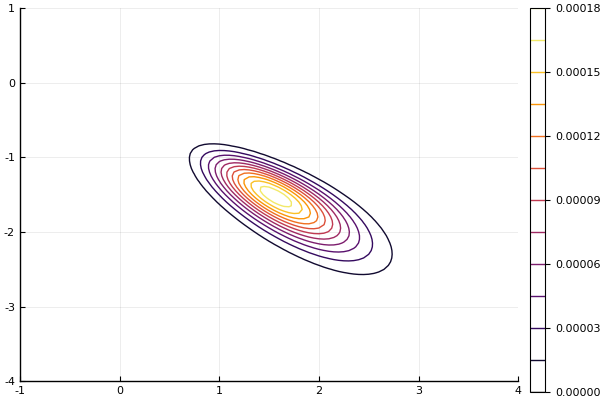

In [1005]:
y = -4:0.05:1
x = -1:0.05:4
gridx = repeat(reshape(x, 1, :), length(y), 1)
gridy = repeat(y, 1, length(x))
f(x,y)= exp(LogPosterior([x y]))
Z = map(f, gridx, gridy)
p1 = contour(x,y, f, fill=false)


3. Run Metropolis-Hastings

Sample $X^*$ from $q(\cdot \mid X_{t-1})$, where $q$ is a random walk centered at $X_{t-1}$. We then accept the new step
with probability $\alpha = min\{1, \frac{\pi(X^*)}{\pi(X_{t-1})} \}$

In [1023]:
# Sample X
burnin = 1_000
steps = 30_000
C = zeros(steps,length(beta))
Xprevious   = [0;0]

for i=1:steps
    Xnew        = Xprevious + randn(2)
    alpha = minimum([1,exp(LogPosterior(Xnew') - LogPosterior(Xprevious'))])
#     println(1 - alpha, Xnew)
    if rand() < (1 - alpha) # Reject
        Xnew = Xprevious
    end
    C[i,:] = Xnew
    Xprevious = Xnew
end

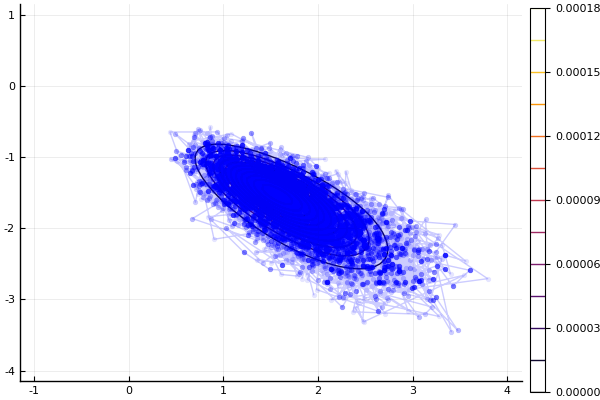

In [1024]:
contour(x,y, f, fill=false)
plot!(C[:,1],C[:,2],marker=:o,color=:blue,alpha=0.2, markeralpha = 0.1, markerstrokewidth=0,legend=false)
# histogram2d!(C[:,1],C[:,2],alpha=0.2)

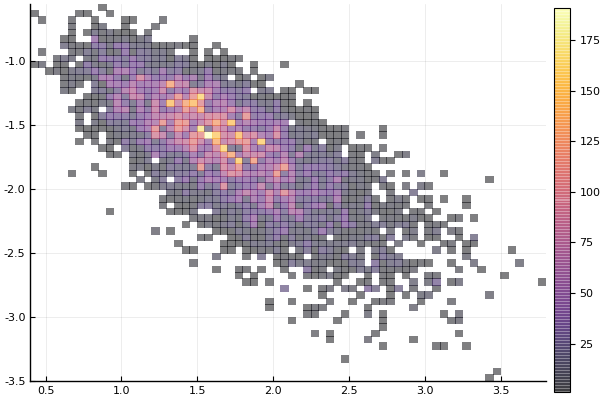

In [1027]:
# Uncomment this to plot the contours instead of the histogram
# density = kde(C[burnin:end,:],boundary=((0.,3),(-4,0)),npoints=((100,100))) #npoints = ((100,100))
# plot(density)


histogram2d(C[:,1],C[:,2],alpha=0.5,nbins=100)

4. For all i = 1, . . . , n, introduce the random variable $Z_i$ distributed as $N (X^T_i \beta, 1)$. Compare the law of
$\mathbb 1_{Z_i≥0}$ with the law of $Y_i$. 

First, note that $Z_i > 0$, when $Y_i =1$, and $Z_i \leq 0$ otherwise.

In [1028]:
# TruncatedNormal()
TruncatedNormal((X*beta')[1],1,-Inf,0) # If Y_i = 0
TruncatedNormal((X*beta')[1],1,0,Inf) # If Y_i = 1

Truncated(Normal{Float64}(μ=-0.4433893697771972, σ=1.0), range=(0.0, Inf))

In [1029]:
rand(TruncatedNormal((X[1,:]'*beta')[1],1,0,Inf))
rand(TruncatedNormal((X[1,:]'*beta')[1],1,-Inf,0)) # If Y_i = 0

-1.1408321408451632

5. Use Z to design a Gibbs sampler, alternatively sampling from β given Z, Y and from Z given β, Y
$$p(\beta \mid Z, Y) = N(\tilde \mu, \tilde \Sigma)$$
Where, $\tilde \Sigma^{-1} = \Sigma^{-1} + \sum^m_{i=1}x_ix_i^T$,
$\tilde \mu = \tilde \Sigma(\Sigma^{-1}\mu + \sum^n_{i=1}x_iz_i)$

In [1030]:
function Sample_Z_Posterior(Y,X,beta)
    Z = zeros(n)
    for i= 1:n
        if Y[i]==1
            Z[i] = rand(TruncatedNormal((X[i,:]'*beta')[1],1,0,Inf)) # If Y_i = 1
        else
            Z[i] = rand(TruncatedNormal((X[i,:]'*beta')[1],1,-Inf,0)) # If Y_i = 0
        end
    end 
    return Z
end

function Sample_beta_Posterior(Z,X)
    B_tilde  = inv(inv(B) + X' * X)
    mu_tilde = B_tilde * (X'*Z)
    return rand(MvNormal(mu_tilde, B_tilde))'
end
Z = Sample_Z_Posterior(Y,X,beta)
Sample_beta_Posterior(Z,X)

1×2 Adjoint{Float64,Array{Float64,1}}:
 1.04535  -0.952715

In [1031]:
steps  = 10_000
GibbsChain = zeros(steps,length(beta))
# B,beta,X,Y
beta_current = beta
for i=1:steps
    Z = Sample_Z_Posterior(Y,X,beta_current)
    beta_current = Sample_beta_posterior(Z, X)
    GibbsChain[i,:] = beta_current
end

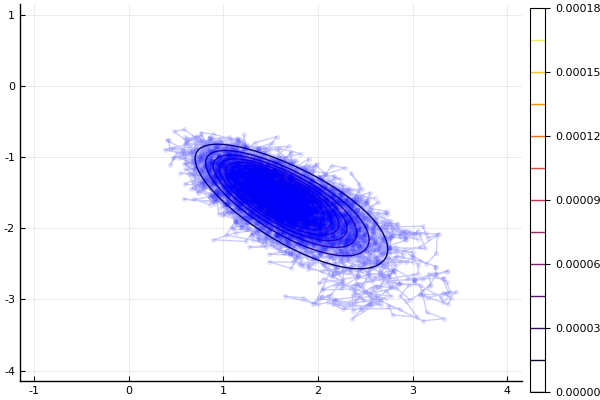

In [1032]:
contour(x,y, f, fill=false)
plot!(GibbsChain[:,1],GibbsChain[:,2],marker=:o,color=:blue,alpha=0.2, markeralpha = 0.1, markerstrokewidth=0,legend=false)

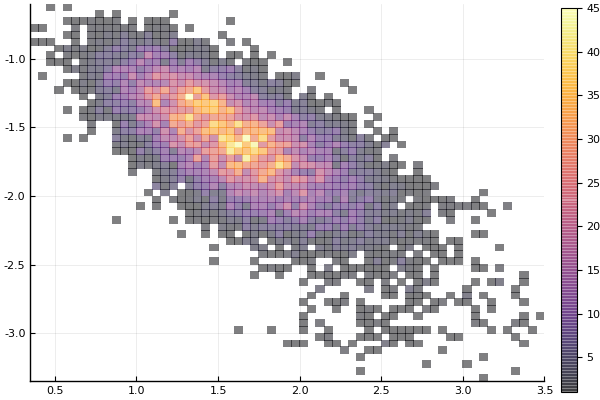

In [1038]:
# Uncomment this to plot the contours instead of the histogram
# contour(x,y, f, fill=false)
# density = kde(GibbsChain[burnin:end,:],boundary=((0.,3),(-4,0)),npoints=((100,100))) #npoints = ((100,100))
# plot(density)


histogram2d(GibbsChain[:,1],GibbsChain[:,2],alpha=0.5,nbins=100)

6. Compare the performance of your Gibbs and Metropolis-Hastings samplers.

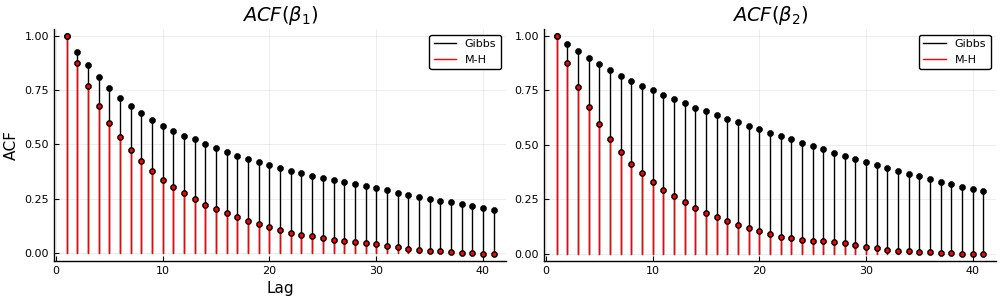

In [1084]:
p1 = plot(autocor(GibbsChain[:,1]),line=:stem,marker=:o,color=:black,label="Gibbs")
p2 = plot!(autocor(C[:,1],(0:1:40)),line=:stem,marker=:o,color=:red,label="M-H",title=L"ACF(\beta_1)",xlabel="Lag",ylabel="ACF")
p3 = plot(autocor(GibbsChain[:,2],(0:1:40)),line=:stem,marker=:o,color=:black,label="Gibbs")
p4 = plot!(autocor(C[:,2],(0:1:40)),line=:stem,marker=:o,color=:red,label="M-H",title=L"ACF(\beta_2)")
plot(p2,p4, layout=2, size=(1000,300))